# Step 6: Spike Count MLP Classification on SHD Dataset

## Objective:
To explore whether high classification performance can be achieved by using **firing rates only**, without any spike timing information.

## Procedure:
- For each sample, compute the spike count of each neuron over the entire time window → resulting in a vector of shape `(num_neurons,)`;
- Use these spike count vectors as input features;
- Train and test a simple MLP (Multi-Layer Perceptron);
- Compare results across three dataset variants:
  - **Whole**: Original dataset with all neurons and all spikes;
  - **Part**: A subset of neurons retained (e.g., the 224 neurons used previously);
  - **Norm**: Same subset of neurons as "Part", but normalized to control total spike count (i.e., equalize information quantity per sample).

## Rationale:
- If good accuracy is achieved using only spike count, it indicates the dataset contains strong **rate-coded information**;
- If accuracy drops significantly, it suggests the model depends on **timing-coded information** (i.e., when spikes occur).

## Expected Outcome:
- The model is expected to perform well on the original dataset;
- Performance may remain unchanged on temporally perturbed data;
- If performance approaches that of SNN models, it suggests rate coding is the dominant factor in the dataset.


In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from utils import get_shd_dataset

cache_dir = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset"
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

base_path = os.path.join(cache_dir, cache_subdir)
train_path = os.path.join(base_path, "shd_train.h5")
test_path = os.path.join(base_path, "shd_test.h5")

train_file = h5py.File(train_path, "r")
test_file = h5py.File(test_path, "r")

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

batch_size = 256
nb_steps = 100
nb_units = 700
max_time = 1.4

def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    labels_ = np.array(y, dtype=np.int32)
    number_of_batches = len(labels_) // batch_size
    sample_index = np.arange(len(labels_))
    firing_times = X['times']
    units_fired = X['units']
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter : batch_size * (counter + 1)]
        dense_batch = np.zeros((batch_size, nb_units, nb_steps), dtype=np.uint8)
        y_batch = []

        for bc, idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            times[times >= nb_steps] = nb_steps - 1
            dense_batch[bc, units, times] = 1
            y_batch.append(labels_[idx])

        yield dense_batch, np.array(y_batch, dtype=np.uint8)
        counter += 1

def collect_all(X_h5, Y_h5):
    X_all = []
    Y_all = []
    gen = sparse_data_generator_from_hdf5_spikes(X_h5, Y_h5,
                                                 batch_size, nb_steps,
                                                 nb_units, max_time,
                                                 shuffle=False)
    for x_batch, y_batch in gen:
        X_all.append(x_batch)
        Y_all.append(y_batch)
    X_all = np.concatenate(X_all, axis=0)
    Y_all = np.concatenate(Y_all, axis=0)
    return X_all, Y_all

X_train_all, Y_train_all = collect_all(x_train, y_train)
X_test_all,  Y_test_all  = collect_all(x_test,  y_test)

X_all = np.concatenate([X_train_all, X_test_all], axis=0)
Y_all = np.concatenate([Y_train_all, Y_test_all], axis=0)

io.savemat("spikedata6_whole_ori.mat", {"X": X_all, "Y": Y_all})
print("Saved: spikedata6_whole_ori.mat")

def do_min_count(X, Y):
    N, F, T = X.shape
    count_all = X.sum(axis=2)
    min_counts = count_all.min(axis=0)

    X_min = np.zeros_like(X)
    for f_idx in range(F):
        N_f = min_counts[f_idx]
        if N_f == 0:
            continue
        for i_idx in range(N):
            spike_times = np.where(X[i_idx, f_idx, :] == 1)[0]
            if len(spike_times) > N_f:
                chosen_times = np.random.choice(spike_times, size=N_f, replace=False)
                X_min[i_idx, f_idx, chosen_times] = 1
            else:
                X_min[i_idx, f_idx, spike_times] = 1
    return X_min, Y

def create_min_count_dataset_avoid_widespread(X, Y, neuron_threshold=2, max_frac_for_neuron=0.01, max_samples_to_remove=1000):
    N, F, T = X.shape
    counts = X.sum(axis=2)
    min_counts_per_neuron = counts.min(axis=0)

    bad_neurons = np.where(min_counts_per_neuron < neuron_threshold)[0]
    print(f"Found {len(bad_neurons)} neurons with min_count < {neuron_threshold}.")

    if len(bad_neurons) == 0:
        return do_min_count(X, Y)

    samples_to_remove = set()
    for f_idx in bad_neurons:
        neuron_counts = counts[:, f_idx]
        i_bad = np.where(neuron_counts < neuron_threshold)[0]
        frac = len(i_bad) / N
        if frac <= max_frac_for_neuron:
            samples_to_remove.update(i_bad)

    if 0 < len(samples_to_remove) < max_samples_to_remove:
        keep_idxs = np.setdiff1d(np.arange(N), list(samples_to_remove))
        X_filtered = X[keep_idxs]
        Y_filtered = Y[keep_idxs]
        print(f"Removing {len(samples_to_remove)} samples.")
    else:
        X_filtered = X
        Y_filtered = Y
        print("NOT removing any samples.")

    return do_min_count(X_filtered, Y_filtered)

X_min, Y_min = create_min_count_dataset_avoid_widespread(
    X_all, Y_all,
    neuron_threshold=2,
    max_frac_for_neuron=0.01,
    max_samples_to_remove=2000
)

sum_over_samples_time = X_min.sum(axis=(0, 2))
zero_mask = (sum_over_samples_time == 0)
non_zero_mask = ~zero_mask

X_norm = X_min[:, non_zero_mask, :]
print(f"After min-count + drop zero neurons => X_norm.shape = {X_norm.shape}")

io.savemat("spikedata6_norm_ori.mat", {"X": X_norm, "Y": Y_min})
print("Saved: spikedata6_norm_ori.mat")

# create part dataset without doing min-count
X_part = X_all[:, non_zero_mask, :]  # save same neurons but original spike save
io.savemat("spikedata6_part_ori.mat", {"X": X_part, "Y": Y_all})
print("Saved: spikedata6_part_ori.mat")


In [ ]:
import numpy as np
import scipy.io as io
import os

def balance_dataset(input_path, output_path):
    """
    Do class balancing for the dataset.
    """
    print(f"\nProcessing: {input_path}")
    data = io.loadmat(input_path)
    X_full = data["X"]
    Y_full = data["Y"].ravel()
    N, num_neurons, T = X_full.shape

    print(f"Loaded dataset: X.shape=({N},{num_neurons},{T}), Y.shape=({len(Y_full)})")

    unique_labels = np.unique(Y_full)
    counts_per_class = {c: np.sum(Y_full == c) for c in unique_labels}
    min_count = min(counts_per_class.values())

    print("--- Sample counts per class ---")
    for c in sorted(unique_labels):
        print(f"Class {c}: {counts_per_class[c]} samples")
    print(f"Using min_count = {min_count}")

    X_list = []
    Y_list = []
    for c in sorted(unique_labels):
        idxs_c = np.where(Y_full == c)[0]
        np.random.shuffle(idxs_c)
        selected = idxs_c[:min_count]
        X_list.append(X_full[selected])
        Y_list.append(Y_full[selected])

    X_bal = np.concatenate(X_list, axis=0)
    Y_bal = np.concatenate(Y_list, axis=0)

    perm = np.random.permutation(len(Y_bal))
    X_bal = X_bal[perm]
    Y_bal = Y_bal[perm]

    print(f"Final balanced shape: X={X_bal.shape}, Y={Y_bal.shape}")
    io.savemat(output_path, {"X": X_bal, "Y": Y_bal})
    print(f"Saved balanced dataset to: {output_path}")


# do the class balance for the original dataset
datasets = [
    ("spikedata6_part_ori.mat",  "spikedata6_part.mat"),
    ("spikedata6_norm_ori.mat",  "spikedata6_norm.mat"),
]

for input_file, output_file in datasets:
    if os.path.exists(input_file):
        balance_dataset(input_file, output_file)
    else:
        print(f"File not found: {input_file}")

# spikedata6_part.mat renames to shd_part.mat
# spikedata6_norm.mat renames to shd_norm.mat


Processing: spikedata6_part_ori.mat
Loaded dataset: X.shape=(9984,224,100), Y.shape=(9984)
--- Sample counts per class ---
Class 0: 488 samples
Class 1: 483 samples
Class 2: 481 samples
Class 3: 502 samples
Class 4: 486 samples
Class 5: 495 samples
Class 6: 487 samples
Class 7: 485 samples
Class 8: 484 samples
Class 9: 487 samples
Class 10: 516 samples
Class 11: 512 samples
Class 12: 510 samples
Class 13: 502 samples
Class 14: 510 samples
Class 15: 513 samples
Class 16: 507 samples
Class 17: 511 samples
Class 18: 508 samples
Class 19: 517 samples
Using min_count = 481
Final balanced shape: X=(9620, 224, 100), Y=(9620,)
Saved balanced dataset to: spikedata6_part.mat

Processing: spikedata6_norm_ori.mat
Loaded dataset: X.shape=(8947,224,100), Y.shape=(8947)
--- Sample counts per class ---
Class 0: 474 samples
Class 1: 474 samples
Class 2: 273 samples
Class 3: 366 samples
Class 4: 462 samples
Class 5: 453 samples
Class 6: 372 samples
Class 7: 446 samples
Class 8: 385 samples
Class 9: 482

In [3]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Begin Here to Train

In [ ]:
import numpy as np
import scipy.io as io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

def load_dataset(mat_path):
    data = io.loadmat(mat_path)
    X = data["X"]  # shape: (N, num_neurons, T)
    Y = data["Y"].ravel()

    # calculate the spike count vector: sum over time
    X_count = X.sum(axis=2).astype(np.float32)  # shape: (N, num_neurons)
    return X_count, Y

X, Y = load_dataset("shd_part.mat")
print(f"Loaded: X.shape = {X.shape}, Y.shape = {Y.shape}")

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

from torch.utils.data import TensorDataset, DataLoader

batch_size = 64
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val)), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), batch_size=batch_size)

num_classes = len(np.unique(Y))
input_dim = X.shape[1]

# define the MLP model
class SpikeMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=20):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikeMLP(input_dim=input_dim, num_classes=num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += len(yb)
    return correct / total

best_val_acc = 0.0
for epoch in range(1, 51):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    val_acc = evaluate(val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "mlp_best.pt")

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Val Acc: {val_acc:.4f}")

model.load_state_dict(torch.load("mlp_best.pt"))
test_acc = evaluate(test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

Loaded: X.shape = (9620, 224), Y.shape = (9620,)
Train: (6734, 224), Val: (1443, 224), Test: (1443, 224)
Epoch   1 | Val Acc: 0.1497
Epoch  10 | Val Acc: 0.2682
Epoch  20 | Val Acc: 0.3125
Epoch  30 | Val Acc: 0.3541
Epoch  40 | Val Acc: 0.3416
Epoch  50 | Val Acc: 0.3645
✅ Final Test Accuracy: 0.3798



🔷 Training on: Whole (All neurons)
Epoch   1: Val Acc = 0.3238
Epoch  10: Val Acc = 0.6515
Epoch  20: Val Acc = 0.7076
Epoch  30: Val Acc = 0.7236
Epoch  40: Val Acc = 0.7009
Epoch  50: Val Acc = 0.7383

🔷 Training on: Part (224 neurons)
Epoch   1: Val Acc = 0.1143
Epoch  10: Val Acc = 0.2911
Epoch  20: Val Acc = 0.3202
Epoch  30: Val Acc = 0.3534
Epoch  40: Val Acc = 0.3493
Epoch  50: Val Acc = 0.3957

🔷 Training on: Norm (224 + min-count)
Epoch   1: Val Acc = 0.0501
Epoch  10: Val Acc = 0.0501
Epoch  20: Val Acc = 0.0501
Epoch  30: Val Acc = 0.0501
Epoch  40: Val Acc = 0.0488
Epoch  50: Val Acc = 0.0501


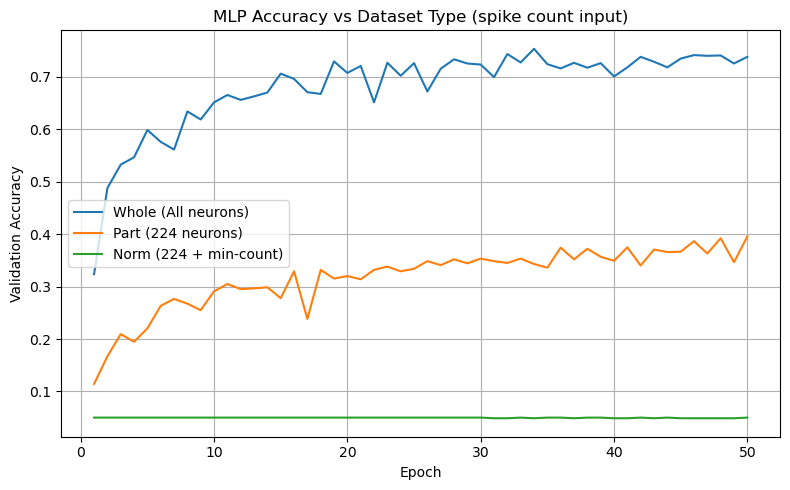

In [ ]:
import numpy as np
import scipy.io as io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

batch_size = 64
num_classes = 20
hidden_dim = 256
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SpikeMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=20):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

def load_count_dataset(mat_path):
    data = io.loadmat(mat_path)
    X = data["X"]  # shape = (N, F, T)
    Y = data["Y"].ravel()
    X_count = X.sum(axis=2).astype(np.float32)
    return X_count, Y

dataset_paths = {
    "Whole (All neurons)": "shd_whole.mat",
    "Part (224 neurons)": "shd_part.mat",
    "Norm (224 + min-count)": "shd_norm.mat"
}

val_acc_curves = {}

for name, path in dataset_paths.items():
    print(f"\n🔷 Training on: {name}")
    X, Y = load_count_dataset(path)
    input_dim = X.shape[1]

    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42)

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val)), batch_size=batch_size)
    test_loader  = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)), batch_size=batch_size)

    model = SpikeMLP(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    val_acc_list = []
    best_val_acc = 0.0

    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += len(yb)
        val_acc = correct / total
        val_acc_list.append(val_acc)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}: Val Acc = {val_acc:.4f}")

    val_acc_curves[name] = val_acc_list

plt.figure(figsize=(8, 5))
for label, curve in val_acc_curves.items():
    plt.plot(range(1, epochs+1), curve, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("MLP Accuracy vs Dataset Type (spike count input)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Train the SNN using 'Part' Dataset

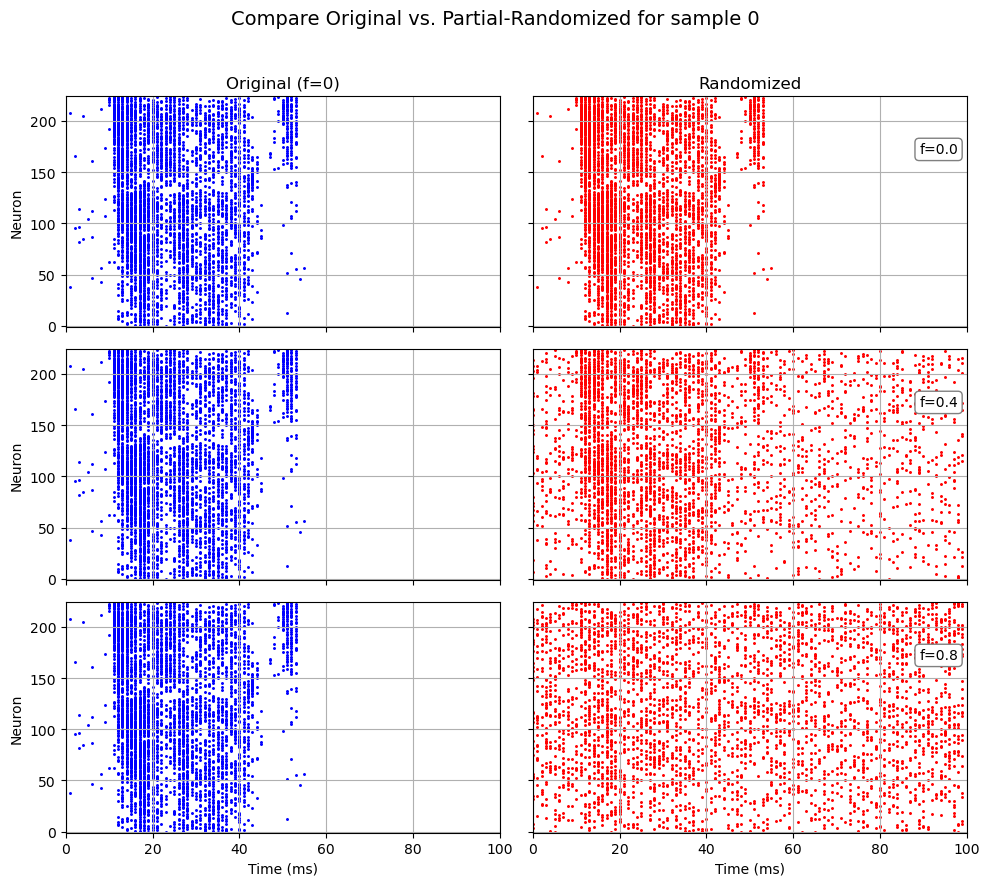

Using data index range = [0, 5772), total 5772 samples
batch_size=2
num_time_points=100
num_batches=2886
RAM usage per batch ~ 0.0003 GB
Got a batch: x_batch.shape=(2, 224, 100), y_batch=[0 9]


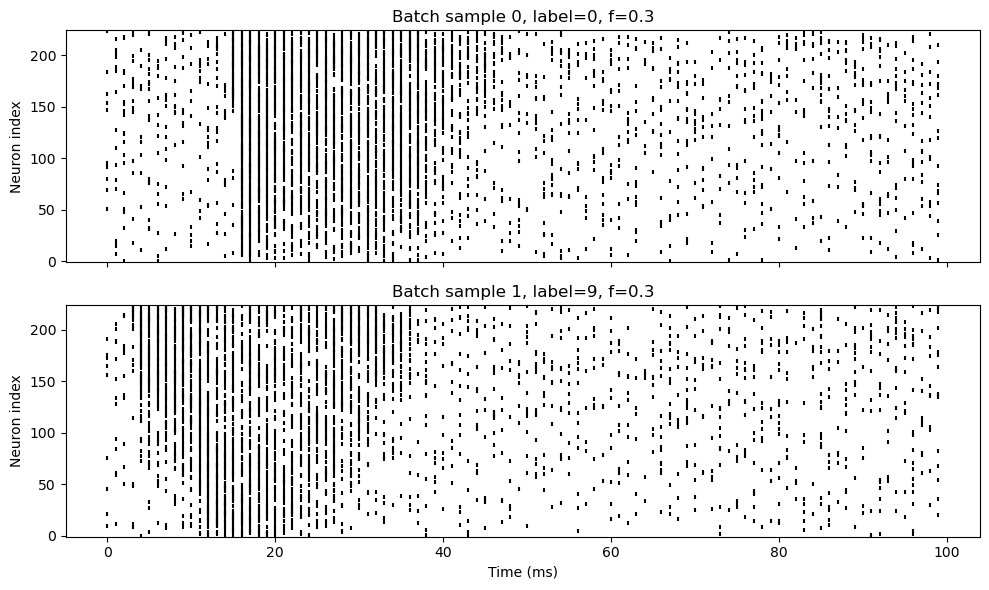

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=500):
    if f <= 0:
        return spike_train

    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        for old_time in spike_times:
            # with probability f, move this spike
            if np.random.rand() < f:
                # 1) clear the old spike position
                new_train[neuron_idx, old_time] = 0

                # 2) insert a new spike at a random time 
                inserted = False
                attempts = 0
                while not inserted and attempts < max_attempts:
                    attempts += 1
                    new_t = np.random.randint(0, T) 
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        inserted = True


    return new_train

    
def num_batches_if(time_fractions, batch_size=32, max_num_batches=None):
    f_start, f_end = time_fractions
    N = X.shape[0]
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    sub_len = end_idx - start_idx
    n_batches = sub_len // batch_size
    if max_num_batches is not None:
        n_batches = min(n_batches, max_num_batches)
    return n_batches

def batched_data(time_fractions, X, Y, batch_size=4, f=0.5,
                 verbose=False, shuffle=True, max_num_batches=None,
                 max_attempts=50):
    N = len(Y)
    f_start, f_end = time_fractions
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    subX = X[start_idx:end_idx]  # [sub_len, n_neurons, T]
    subY = Y[start_idx:end_idx]  # [sub_len]
    sub_len = len(subY)

    indices = np.arange(sub_len)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = sub_len // batch_size
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    num_neurons = X.shape[1]
    num_time_points = X.shape[2]

    if verbose:
        print(f"Using data index range = [{start_idx}, {end_idx}), total {sub_len} samples")
        print(f"{batch_size=}")
        print(f"{num_time_points=}")
        print(f"{num_batches=}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024)**3:.4f} GB")

    for b in range(num_batches):
        batch_idx = indices[b*batch_size : (b+1)*batch_size]
        x_batch = np.zeros((batch_size, subX.shape[1], subX.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)
        for i, sidx in enumerate(batch_idx):
            x_random = partial_randomize_spike_train(subX[sidx], f=f, max_attempts=max_attempts)
            x_batch[i] = x_random
            y_batch[i] = subY[sidx]
        yield x_batch, y_batch

# Load SHD Dataset
from scipy.io import loadmat
data = loadmat("shd_part.mat")
X = data["X"]
Y = data["Y"].ravel()
num_neurons = X.shape[1]
total_samples = X.shape[0]        

training_range   = (0, 0.6)   
validation_range = (0.6, 0.75)
testing_range    = (0.75, 0.9)

def show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.3, 0.9]):
    """
    Do partial randomization for the same sample with different f values.
    """
    original_st = X[sample_idx]  # shape = (n_neurons, T)
    fig, axes = plt.subplots(len(f_values), 2, figsize=(10, 3 * len(f_values)), sharex=True, sharey=True)
    fig.suptitle(f"Compare Original vs. Partial-Randomized for sample {sample_idx}", fontsize=14)

    for row_i, f_ in enumerate(f_values):
        # Left: Original
        ax_left = axes[row_i, 0]
        for neuron_idx in range(original_st.shape[0]):
            spike_times = np.where(original_st[neuron_idx] == 1)[0]
            ax_left.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                            s=5, color='b', marker='.')
        if row_i == 0:
            ax_left.set_title("Original (f=0)")
        ax_left.set_ylabel('Neuron')
        ax_left.grid(True)

        # Right: Partial Randomized
        x_rand = partial_randomize_spike_train(original_st, f=f_)
        ax_right = axes[row_i, 1]
        for neuron_idx in range(x_rand.shape[0]):
            spike_times = np.where(x_rand[neuron_idx] == 1)[0]
            ax_right.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                             s=5, color='r', marker='.')
        if row_i == 0:
            ax_right.set_title("Randomized")
        ax_right.text(0.98, 0.8, f"f={f_:.1f}", transform=ax_right.transAxes,
                      ha='right', va='top', fontsize=10,
                      bbox=dict(boxstyle="round", fc="white", ec="gray"))
        ax_right.grid(True)

        for ax in (ax_left, ax_right):
            ax.set_ylim([-1, original_st.shape[0]])
            ax.set_xlim([0, original_st.shape[1]])

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def demo_batch_visualization(X, Y, time_fractions=(0, 0.2), batch_size=2, f=0.5):
    """
    Use batched_data() to get one batch and do visualization.
    """
    gen = batched_data(time_fractions, X, Y, batch_size=batch_size, f=f, shuffle=True, verbose=True)
    x_batch, y_batch = next(gen)
    print(f"Got a batch: x_batch.shape={x_batch.shape}, y_batch={y_batch}")

    fig, axes = plt.subplots(batch_size, 1, figsize=(10, 3*batch_size), sharex=True, sharey=True)
    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        spike_mat = x_batch[i]  # shape=(n_neurons, T)
        for neuron_idx in range(spike_mat.shape[0]):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=5, marker='|', color='black')
        ax.set_title(f"Batch sample {i}, label={y_batch[i]}, f={f}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim([-1, spike_mat.shape[0]])
    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()


show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.4,0.8])
demo_batch_visualization(X, Y, time_fractions=training_range, batch_size=2, f=0.3)

In [5]:
import torch
import torch.nn as nn
import numpy as np


class SurrGradSpike(torch.autograd.Function):
    scale = 100.0 

    @staticmethod
    def forward(ctx, input):
        """
        在 forward 中做 Heaviside(step) 函数
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        surrogate gradient: d/dx of H(x) ≈ 1/(scale*|x|+1)^2
        """
        (inp,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale*torch.abs(inp) + 1.0)**2
        return grad

spike_fn = SurrGradSpike.apply

# 1) hidden Layer w1 & v1 + (syn, mem) Update
# 2) readout Layer w2 + flt, out Update
# 3) Finally return out_rec, [mem_rec, spk_rec]
class TutorialSNN(nn.Module):
    def __init__(self,nb_inputs=224,nb_hidden=200,nb_outputs=20,time_step=1e-3,
                 tau_mem=10e-3,tau_syn=5e-3,weight_scale=0.2,device='cpu'):
        """
        w1, w2, v1 都用 normal_(..., std=weight_scale/sqrt(...))
        alpha, beta = exp(-dt/tau_syn), exp(-dt/tau_mem)
        """
        super().__init__()

        self.nb_inputs  = nb_inputs
        self.nb_hidden  = nb_hidden
        self.nb_outputs = nb_outputs
        self.time_step  = time_step
        self.tau_mem    = tau_mem
        self.tau_syn    = tau_syn
        self.device_str = device

        # w1 => (n_in, n_hidden)
        self.w1 = nn.Parameter(torch.empty((nb_inputs, nb_hidden), dtype=torch.float))
        # v1 => (n_hidden, n_hidden)
        self.v1 = nn.Parameter(torch.empty((nb_hidden, nb_hidden), dtype=torch.float))
        # w2 => (n_hidden, n_outputs)
        self.w2 = nn.Parameter(torch.empty((nb_hidden, nb_outputs), dtype=torch.float))

        # init
        torch.nn.init.normal_(self.w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
        torch.nn.init.normal_(self.w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
        torch.nn.init.normal_(self.v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

        # alpha, beta
        self.alpha = float(np.exp(-time_step / tau_syn))
        self.beta  = float(np.exp(-time_step / tau_mem))

    def forward(self, inputs, dtype=torch.float32):
        """
        inputs shape = (batch_size, nb_steps, nb_inputs)
        h1_from_input = einsum('abc,cd->abd',(inputs, w1))
        Finally return out_rec, [mem_rec, spk_rec]
        """
        if inputs.dim() == 3:
            inputs = inputs.permute(0, 2, 1)  # (B, T, input_size)

        device = torch.device(self.device_str if torch.cuda.is_available() else 'cpu')
        inputs = inputs.to(device=device, dtype=dtype)
        batch_size, nb_steps, _ = inputs.shape 

        # hidden states
        syn = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)

        mem_rec = []
        spk_rec = []

        # 1) Calculate input->hidden
        # inputs shape => (B,T,n_in) w1 => (n_in,n_hidden) => result => (B,T,n_hidden)
        h1_from_input = torch.einsum("abc,cd->abd", (inputs, self.w1.to(inputs.device)))

        # 2) nb_steps
        for t in range(nb_steps):
            # recurrent: out =>(B,n_hidden), v1=>(n_hidden,n_hidden) => shape(B,n_hidden)
            rec_input = torch.einsum("ab,bc->ac", (out, self.v1.to(inputs.device)))
            h1 = h1_from_input[:, t, :] + rec_input

            # mem-1 => spike
            mthr = mem - 1.0
            out_new = spike_fn(mthr)
            rst = out_new.detach()  # not backprop

            # new_syn= alpha*syn + h1
            # new_mem= (beta*mem + syn)*(1.0 - rst)
            new_syn = self.alpha*syn + h1
            new_mem = (self.beta*mem + syn)*(1.0 - rst)
            mem_rec.append(mem)
            spk_rec.append(out_new)
            mem = new_mem
            syn = new_syn
            out = out_new

        mem_rec = torch.stack(mem_rec, dim=1)
        spk_rec = torch.stack(spk_rec, dim=1)

        # 3) readout layer
        #  spk_rec => shape(B, nb_steps, n_hidden)
        h2 = torch.einsum("abc,cd->abd", (spk_rec, self.w2.to(inputs.device)))

        # flt, out =>(B, nb_outputs)
        flt = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_read = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_rec = [out_read]

        for t in range(nb_steps):
            new_flt = self.alpha*flt + h2[:, t, :]
            new_out = self.beta*out_read + flt
            flt = new_flt
            out_read = new_out
            out_rec.append(out_read)

        # =>(nb_steps+1, B, nb_outputs)->(B, nb_steps+1, nb_outputs)
        out_rec = torch.stack(out_rec, dim=1)
        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs


In [6]:
import torch
import torch.nn.functional as F
import numpy as np

num_classes = 20

def evaluate_network(net, time_fractions, batch_size=64, f=0.0, device='cpu'):
    """
    Evaluate: max-over-time + NLL loss + null baseline
    """
    net.eval()
    losses = []
    null_losses = []
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y,batch_size=batch_size,f=f, shuffle=False,max_num_batches=2)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, other_recs = net(x_t)
            m, _ = torch.max(out_rec, dim=1)  # => (B, nb_outputs)
            log_probs = log_softmax_fn(m)

            y_t = y_t.to(log_probs.device)
            loss_val = loss_fn(log_probs, y_t)
            losses.append(loss_val.item())

            # null_loss: log_softmax(zeros)
            zero_logits = torch.zeros_like(m)
            null_lp = log_softmax_fn(zero_logits)
            null_val = loss_fn(null_lp, y_t)
            null_losses.append(null_val.item())

    avg_loss = np.mean(losses) if len(losses) else 0.
    avg_null = np.mean(null_losses) if len(null_losses) else 0.
    return avg_loss, avg_null

## 对每个 batch -> run_snn-> out_rec + spk_rec 计算 cross_entropy + spike regularizer 优化器用 Adamax
def train_model(f=0.0, num_epochs=100, batch_size=64, max_num_batches=40,
                lr=2e-4, hidden_units=200, device='cuda', seed=42):
    print(f"\n=== Training model with f={f}, num_epochs={num_epochs}, seed={seed} ===")

    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    dev = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {dev}")

    net = TutorialSNN(num_neurons, hidden_units, num_classes).to(dev)

    optimizer = torch.optim.Adamax(net.parameters(), lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    best_model_state = None

    train_batches = num_batches_if(training_range,batch_size=batch_size,max_num_batches=max_num_batches)
    total_batches = num_epochs * train_batches

    from tqdm import tqdm
    with tqdm(total=total_batches) as pbar:
        for epoch in range(num_epochs):
            net.train()
            local_losses = []

            train_gen = batched_data(training_range, X, Y, batch_size=batch_size, f=f,
                                     shuffle=True, verbose=(epoch==0), max_num_batches=max_num_batches)

            for x_np, y_np in train_gen:
                x_t = torch.tensor(x_np, dtype=torch.float32, device=dev)
                y_t = torch.tensor(y_np, dtype=torch.long, device=dev)

                out_rec, other_recs = net(x_t)
                spk_rec = other_recs[1]

                m, _ = torch.max(out_rec, dim=1)
                log_probs = log_softmax_fn(m)

                l1_loss = 2e-6 * torch.sum(spk_rec)
                sum_per_neuron = torch.sum(spk_rec, dim=[0,1])  # (hidden,)
                l2_loss = 2e-6 * torch.mean(sum_per_neuron**2)

                reg_loss = l1_loss + l2_loss

                y_t = y_t.to(log_probs.device)
                loss_val = loss_fn(log_probs, y_t) + reg_loss
                local_losses.append(loss_val.item())

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                pbar.update(1)

            last_epoch_loss = np.mean(local_losses) if local_losses else 0.
            val_loss, null_val_loss = evaluate_network(net,validation_range,batch_size=64,f=f,device=dev)

            val_loss_hist.append(val_loss)
            loss_hist.append(last_epoch_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = net.state_dict()

            pbar.set_postfix(epoch=epoch,train_loss=last_epoch_loss,val_loss=val_loss,null_val=null_val_loss)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.semilogy(loss_hist, label='Train loss')
    plt.semilogy(val_loss_hist, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if best_model_state is not None:
        net.load_state_dict(best_model_state)
        print(f"Loaded best model with val_loss={best_val_loss:.4f}")

    test_loss, null_test_loss = evaluate_network(net,testing_range,batch_size=64,f=f,device=dev)
    print(f"Final Test: test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")

    return net, best_val_loss

def test_accuracy(net, time_fractions=testing_range, batch_size=64, f=0, device='cpu'):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y,batch_size=batch_size,f=f,shuffle=False,max_num_batches=40)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, _ = net(x_t, dtype=x_t.dtype)

            # max over time => (B,O)
            m, _ = torch.max(out_rec, dim=1)
            preds = torch.argmax(m, dim=1)  # shape=(B,)

            y_t = y_t.to(preds.device)
            correct += (preds == y_t).sum().item()
            total   += y_t.shape[0]

    acc = correct/total if total>0 else 0.
    return acc



### Training model for f = 0.0 ###

=== Training model with f=0.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5772), total 5772 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [29:20<00:00,  3.41it/s, epoch=149, null_val=3, train_loss=1.17, val_loss=1.2] 


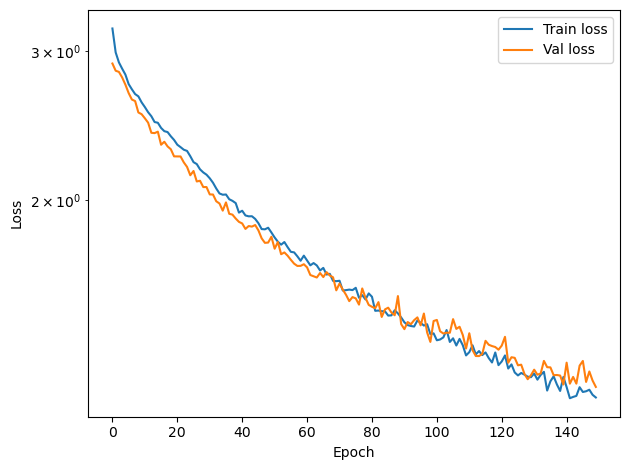

Loaded best model with val_loss=1.1999
Final Test: test_loss=1.2192, null_test_loss=2.9957
Saved model: s6_f00.pt
f=0.0, Test Accuracy: 58.24%

### Training model for f = 0.2 ###

=== Training model with f=0.2, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5772), total 5772 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [1:30:21<00:00,  1.11it/s, epoch=149, null_val=3, train_loss=1.35, val_loss=1.41]


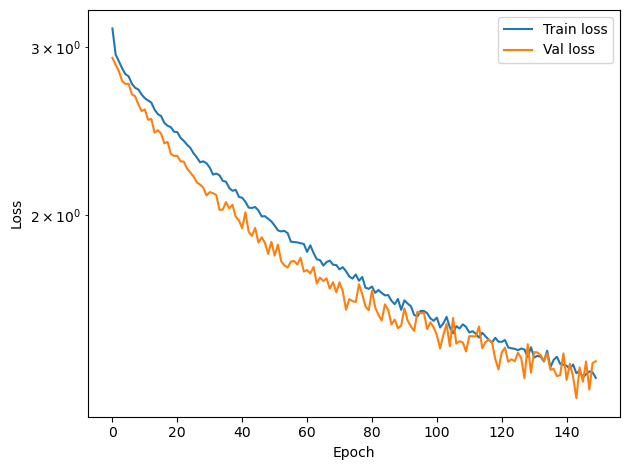

Loaded best model with val_loss=1.2874
Final Test: test_loss=1.3072, null_test_loss=2.9957
Saved model: s6_f02.pt
f=0.2, Test Accuracy: 55.11%

### Training model for f = 0.4 ###

=== Training model with f=0.4, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5772), total 5772 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [1:20:39<00:00,  1.24it/s, epoch=149, null_val=3, train_loss=1.57, val_loss=1.59]


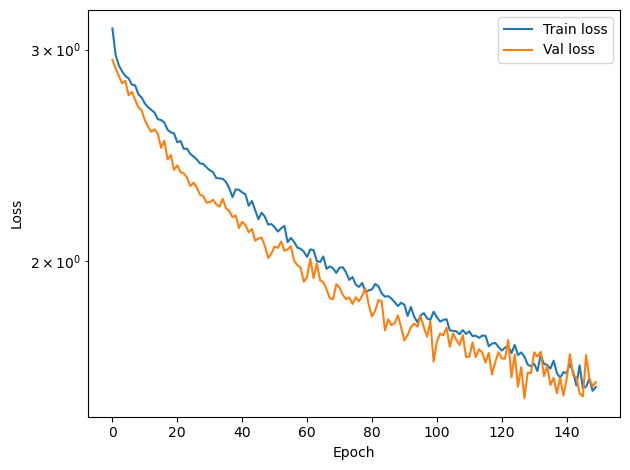

Loaded best model with val_loss=1.5371
Final Test: test_loss=1.5375, null_test_loss=2.9957
Saved model: s6_f04.pt
f=0.4, Test Accuracy: 48.86%

### Training model for f = 0.6 ###

=== Training model with f=0.6, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5772), total 5772 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [1:34:13<00:00,  1.06it/s, epoch=149, null_val=3, train_loss=1.82, val_loss=1.75]


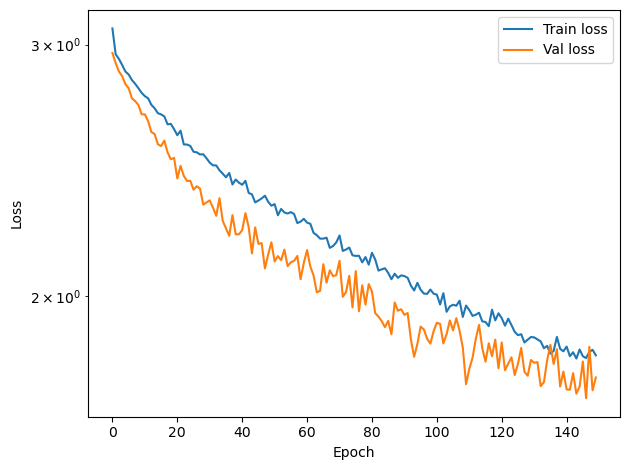

Loaded best model with val_loss=1.6953
Final Test: test_loss=1.6667, null_test_loss=2.9957
Saved model: s6_f06.pt
f=0.6, Test Accuracy: 42.47%

### Training model for f = 0.8 ###

=== Training model with f=0.8, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5772), total 5772 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [2:25:09<00:00,  1.45s/it, epoch=149, null_val=3, train_loss=1.92, val_loss=1.84]  


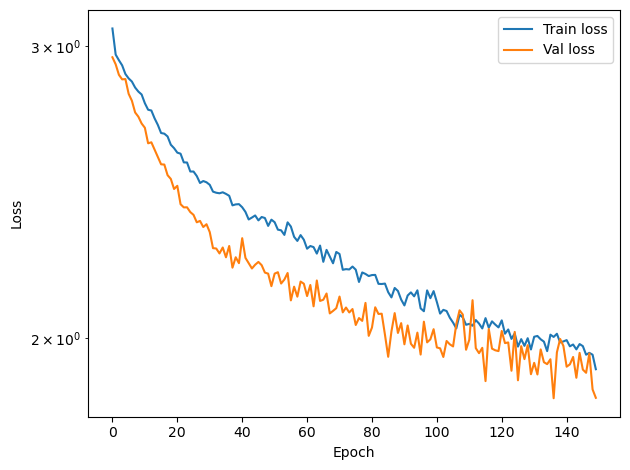

Loaded best model with val_loss=1.8409
Final Test: test_loss=1.8862, null_test_loss=2.9957
Saved model: s6_f08.pt
f=0.8, Test Accuracy: 35.23%

### Training model for f = 1.0 ###

=== Training model with f=1.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 5772), total 5772 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [2:13:17<00:00,  1.33s/it, epoch=149, null_val=3, train_loss=1.88, val_loss=1.94]  


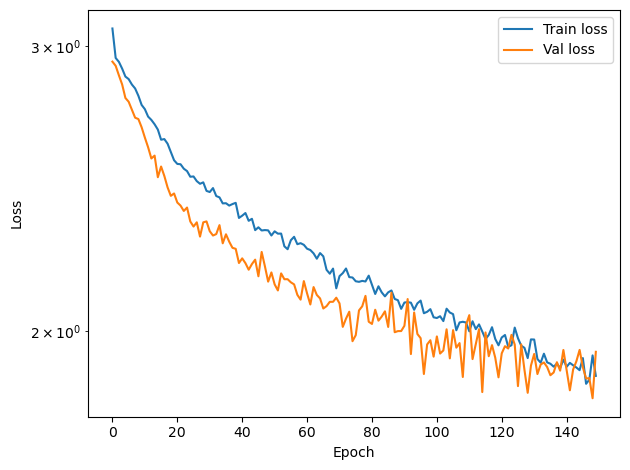

Loaded best model with val_loss=1.8171
Final Test: test_loss=1.8527, null_test_loss=2.9957
Saved model: s6_f10.pt
f=1.0, Test Accuracy: 38.57%


In [8]:
f_values = [0.0,0.2,0.4,0.6,0.8,1.0]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"s6_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

def test_accuracy_repeats(net, repeats=5, f=0.0):
    """
    Under same f value, test repeats times
    """
    acc_list = []
    for r in range(repeats):

        acc = test_accuracy(net,
                            time_fractions=testing_range,
                            batch_size=256,
                            f=f,
                            device=device)
        acc_list.append(acc)
    return acc_list

all_means = []
all_stds = []

repeats = 5 

for f in f_values:
    model_path = f"s6_f{int(f*10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing (f={f}) ===")

    net = TutorialSNN(num_neurons, 200, num_classes)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()

    acc_list = test_accuracy_repeats(net, repeats=repeats, f=f)
    mean_acc = np.mean(acc_list)
    std_acc  = np.std(acc_list)

    all_means.append(mean_acc)
    all_stds.append(std_acc)

    print(f"f={f:.1f}, Mean Acc={mean_acc:.2%}, Std={std_acc:.2%} (over {repeats} runs)")


plt.figure(figsize=(6, 4))

means_pct = [m * 100 for m in all_means]
stds_pct  = [s * 100 for s in all_stds]

plt.errorbar(f_values, means_pct, yerr=stds_pct,
             fmt='-o', color='b', ecolor='r', capsize=3,
             label='Test Accuracy (%)')

plt.xlabel("f (randomization level)")
plt.ylabel("Accuracy (%)")
plt.title(f"Effect of f on Test Accuracy (with {repeats} repeats)")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()